In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
from dataclasses import dataclass
import math
import time
import inspect
from pathlib import Path
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
from torch.nn import functional as F

In [5]:
!nvidia-smi

Thu Sep 18 20:53:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GH200 480GB             On  |   00000000:DD:00.0 Off |                    0 |
| N/A   34C    P0             69W /  700W |       0MiB /  97871MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [6]:
torch.manual_seed(1337)
random.seed(1337)
data_path = Path('/home/ubuntu/data')
log_path = Path('/home/ubuntu/log')
model_path = Path('/home/ubuntu/model')


def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

device = get_device()

using cuda


## Model

In [7]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        # ensures that you can split embeddings across the heads
        assert config.n_embd % config.n_head == 0
        # key, query, value projection for all heads in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, n_embd embedding dimensionality 
        # calculate query, key, value for all heads in batch, then move head forward
        # nh - num heads, hs - head size, C  nh*hs aka channels
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        # y = att @ v # (B, nh, T, T) X (B, nh, T, hs) - > (B, nh, T, hs)
        # replace attention with flash attention 
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        # allows for pathway to pass through gradients instead of going through each "box"
        # this is a feed forward network
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length/context
    vocab_size: int = 100276 # switched to GP4 tokenizer 
    n_layer: int = 12 
    n_head: int = 12
    n_embd: int = 768

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd), # weight tokenizer element
            wpe = nn.Embedding(config.block_size, config.n_embd), # weight position element
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # hidden layers aka Transformers
            ln_f = nn.LayerNorm(config.n_embd), #log normalization 
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # language model head going from embeddings to vocab

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        mean = 0.0
        if isinstance(module, nn.Linear):
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=mean, std=std)

    def forward(self, idx, targets=None):
        # idx is shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f'Cannot forward sequence, out of context'
        # forward the token and positions
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # (T, n_embd)
        tok_emb = self.transformer.wte(idx) # (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the block
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and head
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f'num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters')
        print(f'num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters')
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        print(f'using fused AdamW: {use_fused}')
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer

In [8]:
def load_tokens(filename):
    print(f'loading {filename}')
    npt = np.load(filename)
    npt = npt.astype(np.int32)
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt

class DataLoaderLite:
    def __init__(self, B, T, split):
        self.B = B
        self.T = T
        assert split in {'train','test','val'}

        # get the shard filenames
        data_root = data_path / f'{split}'
        shards = list(data_root.iterdir())
        self.shards = sorted(shards)
        assert len(shards) > 0, f'no shards found for split {split}'
        print(f'found {len(shards)} shards for split {split}')
        self.reset()

    def reset(self):
        # state, init at shard zero
        self.remaining_shards = self.shards
        random.shuffle(self.remaining_shards)
        self.current_shard = 0
        self.tokens = load_tokens(self.remaining_shards[self.current_shard])
        self.current_position = self.B * self.T

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        if len(buf) < B * T + 1:
            self.current_shard += 1
            if self.current_shard >= len(self.remaining_shards):
                self.reset()
            self.tokens = load_tokens(self.remaining_shards[self.current_shard])
            self.current_position = B * T
            return self.next_batch()
        x = (buf[:-1]).view(B, T)
        y = (buf[1:]).view(B, T)
        self.current_position += B * T
        return x, y

## Setup run

In [9]:
# torchrun command sets the env variables RANK, LOCAL_RANK, and WORLD_SIZE
device_type = device 


In [11]:
total_batch_size = 589824 #524288 # a little more than 2**19, to fit the B & T
B = 96 # micro batch size
T = 1024 # sequence length
assert total_batch_size % (B * T) == 0, 'make sure total_batch_size is divisible by B * T'
grad_accum_steps = total_batch_size // (B * T)

print(f'total desired batch size: {total_batch_size}')
print(f'=> calculated gradient accumulation steps: {grad_accum_steps}')

train_loader = DataLoaderLite(B=B, T=T, split='train')
test_loader = DataLoaderLite(B=B, T=T, split='test')

torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig(vocab_size=100608)) # make divisible by power of 2 was 50304
model.to(device)
model = torch.compile(model)

    
raw_model = model # always contains the "raw" unwrapped model
lossi = []

total desired batch size: 589824
=> calculated gradient accumulation steps: 6
found 289 shards for split train
loading /home/ubuntu/data/train/train_0000271.npy
found 2 shards for split test
loading /home/ubuntu/data/test/test_0000001.npy


In [12]:
max_lr = 2e-3 
min_lr = max_lr * 0.005
max_steps = 50862  # ~ 30B tokens, 2**19 tokens per batch, so 1.04 epoch (1 epoch ~= 48998) 
warmup_steps = 0.001 * max_steps # 5% warmup
weight_decay = 0.1
def get_lr(it):
    # 1/ linear warmup 
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2/ if iterations > lr_decay_iters, return min learning rate
    if it > max_steps: 
        return min_lr

    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

In [13]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=min_lr, betas=(0.9, 0.95), eps=1e-8)
optimizer = raw_model.configure_optimizers(weight_decay=0.1, learning_rate=max_lr, device_type=device_type)
enc = tiktoken.get_encoding('cl100k_base')

num decayed parameter tensors: 50, with 162,988,032 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True


In [14]:
log_file = log_path / 'logs.txt'
with open(log_file, 'w') as f: # open for writing to clear the file
    pass

In [15]:
for step in range(max_steps):
    t0 = time.time()
    last_step = (step == max_steps - 1)
    
    # once in a while evaluate our test loss
    if step % 500 == 0 or last_step:
        model.eval()
        test_loader.reset()
        with torch.no_grad():
            test_loss_accum = 0.0
            test_loss_steps = 20
            for _ in range(test_loss_steps):
                x, y = test_loader.next_batch()
                x, y = x.to(device), y.to(device)
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(x, y)
                loss = loss / test_loss_steps
                test_loss_accum += loss.detach()
        
        print(f'test loss: {test_loss_accum.item():.4f}')
        with open(log_file, "a") as f:
            f.write(f'{step} test {test_loss_accum.item():.4f}\n')
        if step > 0 and (step % 5000 == 0 or last_step):
            # optionally write model checkpoints
            checkpoint_path = model_path / f'model_{step:05d}.pt'
            checkpoint = {
                'model': raw_model.state_dict(),
                'config': raw_model.config,
                'step': step,
                'test_loss': test_loss_accum.item()
            }
            # you might also want to add optimizer.state_dict() and
            # rng seeds etc., if you wanted to more exactly resume training
            torch.save(checkpoint, checkpoint_path)

    # once in a while generate from the model (except step 0, which is noise)
    if ((step > 0 and step % 500 == 0) or last_step):
        model.eval()
        num_return_sequences = 2
        max_length = 32
        tokens = enc.encode('Who the fuck are you? I\'m the fucking')
        tokens = torch.tensor(tokens, dtype=torch.long)
        tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
        xgen = tokens.to(device)
        sample_rng = torch.Generator(device=device)
        sample_rng.manual_seed(42)
        while xgen.size(1) < max_length:
            # forward the model to get the logits
            with torch.no_grad():
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(xgen) # (B, T, vocab_size)
                # take the logits at the last position
                logits = logits[:, -1, :] # (B, vocab_size)
                # get the probabilities
                probs = F.softmax(logits, dim=-1)
                # do top-k sampling of 50 (huggingface pipeline default)
                # topk_probs here becomes (5, 50), topk_indices is (5, 50)
                topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
                # select a token from the top-k probabilities
                # note: multinomial does not demand the input to sum to 1
                ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
                # gather the corresponding indices
                xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
                # append to the sequence
                xgen = torch.cat((xgen, xcol), dim=1)
        # print the generated text
        for i in range(num_return_sequences):
            tokens = xgen[i, :max_length].tolist()
            decoded = enc.decode(tokens)
            print(f'sample {i}: {decoded}')

    # do one step of the optimization
    model.train()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    # determine and set the learning rate for this iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    if device_type == 'cuda':
        torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = t1 - t0 # time difference in seconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps 
    tokens_per_sec = tokens_processed / dt

    lossi.append(loss_accum.item())
    print(f'step {step:5d} | loss: {loss_accum.item():.6f} | lr {lr:.4e}| dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}')
    with open(log_file, 'a') as f:
        f.write(f'{step} train {loss_accum.item():.6f}\n')

loading /home/ubuntu/data/test/test_0000000.npy
test loss: 11.6744
step     0 | loss: 11.674034 | lr 3.9322e-05| dt: 68407.42ms | tok/sec: 8622.22
step     1 | loss: 11.027431 | lr 7.8644e-05| dt: 1760.87ms | tok/sec: 334962.15
step     2 | loss: 10.687360 | lr 1.1797e-04| dt: 1555.05ms | tok/sec: 379296.68
step     3 | loss: 10.484073 | lr 1.5729e-04| dt: 1532.54ms | tok/sec: 384867.35
step     4 | loss: 10.370975 | lr 1.9661e-04| dt: 1540.91ms | tok/sec: 382776.00
step     5 | loss: 10.211422 | lr 2.3593e-04| dt: 1534.36ms | tok/sec: 384409.62
step     6 | loss: 10.160280 | lr 2.7525e-04| dt: 1538.80ms | tok/sec: 383302.28
step     7 | loss: 9.966030 | lr 3.1458e-04| dt: 1542.18ms | tok/sec: 382461.06
step     8 | loss: 9.612383 | lr 3.5390e-04| dt: 1540.49ms | tok/sec: 382880.79
step     9 | loss: 9.372849 | lr 3.9322e-04| dt: 1538.95ms | tok/sec: 383263.74
step    10 | loss: 9.088731 | lr 4.3254e-04| dt: 1538.48ms | tok/sec: 383379.92
step    11 | loss: 8.972555 | lr 4.7187e-04| dt

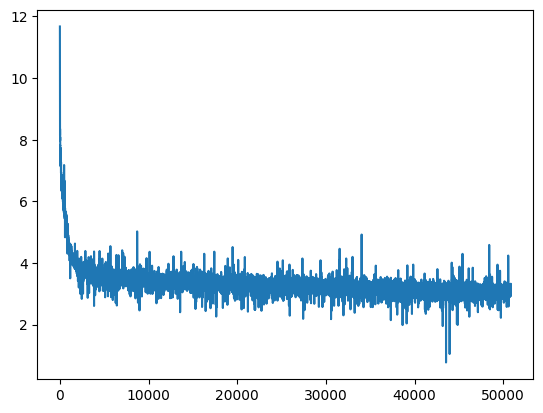

In [16]:
plt.plot(lossi)

In [17]:
model.eval()
num_return_sequences = 1
max_length = 1000
tokens = enc.encode('My fucking purpose is')
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)
sample_rng = torch.Generator(device=device)
while xgen.size(1) < max_length:
    # forward the model to get the logits
    with torch.no_grad():
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss = model(xgen) # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        xgen = torch.cat((xgen, xcol), dim=1)
# print the generated text
for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f'sample {i}: {decoded}')

sample 0: My fucking purpose is to show you in no particular order any of the amazing books which made me write this entire book. No one asked me to list it. However I did list out the novels which I am sure all my friends will be reading.
When I saw the cover and the title it was so great it blew me away at first!
Anyway back to writing this book.
I will say I wasn't expecting much to show. I am more of a reader than a book reviewer. I was just saying we all have our strengths and weaknesses so make the effort. I'm going to pick up on the positives and write them down more.
However, as an adult, some of you are reading more than others of the books I mentioned in the above. This section gave me the freedom to go away for the rest of my day to see what books the people who I am writing to is reading next and to pick them up to read.
The big book I mentioned was the two volumes of a book titled 'The Sins of the Fathers.' It is hard to really put into words or find the words to describe 

### HellaSwag Eval

In [18]:
import os
import json
import requests
import tiktoken
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import GPT2LMHeadModel
from pathlib import Path

/home/ubuntu/miniconda3/envs/general/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
DATA_CACHE_DIR = model_path = Path('~/data/hellaswag')

def download_file(url: str, fname: str, chunk_size=1024):
    """Helper function to download a file from a given url"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(fname, "wb") as file, tqdm(
        desc=fname,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

hellaswags = {
    "train": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_train.jsonl",
    "val": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_val.jsonl",
    "test": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_test.jsonl",
}

enc = tiktoken.get_encoding("gpt2")

def download(split):
    """Downloads HellaSwag DATA_CACHE_DIR"""
    os.makedirs(DATA_CACHE_DIR, exist_ok=True)
    data_url = hellaswags[split]
    data_filename = os.path.join(DATA_CACHE_DIR, f"hellaswag_{split}.jsonl")
    if not os.path.exists(data_filename):
        print(f"Downloading {data_url} to {data_filename}...")
        download_file(data_url, data_filename)

def render_example(example):
    """
    Given the example as a dictionary, render it as three torch tensors:
    - tokens (the tokens of context + completion, of size 4xN, as there are always 4 candidates)
    - mask (is 1 in the region of the candidate completion, where we evaluate likelihoods)
    - label (the index of the correct completion, which we hope has the highest likelihood)
    """
    ctx = example["ctx"]
    label = example["label"]
    endings = example["endings"]

    # data needed to reproduce this eval on the C size
    data = {
        "label": label,
        "ctx_tokens": None,
        "ending_tokens": [],
    }

    # gather up all the tokens
    ctx_tokens = enc.encode(ctx)
    data["ctx_tokens"] = ctx_tokens
    tok_rows = []
    mask_rows = []
    for end in endings:
        end_tokens = enc.encode(" " + end) # note: prepending " " because GPT-2 tokenizer
        tok_rows.append(ctx_tokens + end_tokens)
        mask_rows.append([0]*len(ctx_tokens) + [1]*len(end_tokens))
        data["ending_tokens"].append(end_tokens)

    # have to be careful during the collation because the number of tokens in each row can differ
    max_len = max(len(row) for row in tok_rows)
    tokens = torch.zeros((4, max_len), dtype=torch.long)
    mask = torch.zeros((4, max_len), dtype=torch.long)
    for i, (tok_row, mask_row) in enumerate(zip(tok_rows, mask_rows)):
        tokens[i, :len(tok_row)] = torch.tensor(tok_row)
        mask[i, :len(mask_row)] = torch.tensor(mask_row)

    return data, tokens, mask, label

def iterate_examples(split):
    # there are 10,042 examples in total in val
    download(split)
    with open(os.path.join(DATA_CACHE_DIR, f"hellaswag_{split}.jsonl"), "r") as f:
        for line in f:
            example = json.loads(line)
            yield example

@torch.no_grad()
def evaluate(model_type, device):

    torch.set_float32_matmul_precision('high') # use tf32
    model = GPT2LMHeadModel.from_pretrained(model_type)
    model.to(device)
    # model = torch.compile(model) # optionally torch compile the model

    num_correct_norm = 0
    num_correct = 0
    num_total = 0
    for example in iterate_examples("val"):
        data, tokens, mask, label = render_example(example)
        tokens = tokens.to(device)
        mask = mask.to(device)

        # get the logits
        logits = model(tokens).logits
        # evaluate the autoregressive loss at all positions
        shift_logits = (logits[..., :-1, :]).contiguous()
        shift_tokens = (tokens[..., 1:]).contiguous()
        flat_shift_logits = shift_logits.view(-1, shift_logits.size(-1))
        flat_shift_tokens = shift_tokens.view(-1)
        shift_losses = F.cross_entropy(flat_shift_logits, flat_shift_tokens, reduction='none')
        shift_losses = shift_losses.view(tokens.size(0), -1)
        # now get the average loss just for the completion region (where mask == 1), in each row
        shift_mask = (mask[..., 1:]).contiguous() # we must shift mask, so we start at the last prompt token
        masked_shift_losses = shift_losses * shift_mask
        # sum and divide by the number of 1s in the mask
        sum_loss = masked_shift_losses.sum(dim=1)
        avg_loss = sum_loss / shift_mask.sum(dim=1)
        # now we have a loss for each of the 4 completions
        # the one with the lowest loss should be the most likely
        pred = sum_loss.argmin().item()
        pred_norm = avg_loss.argmin().item()

        # accumulate stats
        num_total += 1
        num_correct += int(pred == label)
        num_correct_norm += int(pred_norm == label)
        print(f"{num_total} acc_norm: {num_correct_norm}/{num_total}={num_correct_norm/num_total:.4f}")

        # debug: pretty print a few examples, and the losses in each case
        if num_total < 10:
            print("---")
            print(f"Context:\n {example['ctx']}")
            print(f"Endings:")
            for i, end in enumerate(example["endings"]):
                print(f"{i} (loss: {avg_loss[i].item():.4f}) {end}")
            print(f"predicted: {pred_norm}, actual: {label}")

In [26]:
num_correct_norm = 0
num_total = 0
for i, example in enumerate(iterate_examples("val")):
    # render the example into tokens and labels
    _, tokens, mask, label = render_example(example)
    tokens = tokens.to(device)
    mask = mask.to(device)
    # get the logits
    with torch.no_grad():
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss = model(tokens)
        pred_norm = get_most_likely_row(tokens, mask, logits)
    num_total += 1
    num_correct_norm += int(pred_norm == label)

acc_norm = num_correct_norm / num_total

print(f"HellaSwag accuracy model_50862 30B tokens: {num_correct_norm}/{num_total}={acc_norm:.4f}")
print(f"HellaSwag accuracy                  GPT-2: 2968/10042=0.2956")

HellaSwag accuracy model_50862 30B tokens: 2756/10042=0.2744
HellaSwag accuracy                  GPT-2: 2968/10042=0.2956
